## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

from fastai.vision import *
np.random.seed(42) # so that we'll get the same split every time

### Get data

`'/home/paperspace/.fastai/data/planet'`

In [3]:
path = pathlib.Path('/home/paperspace/.fastai/data/planet'); path

PosixPath('/home/paperspace/.fastai/data/planet')

In [4]:
path.ls()

[PosixPath('/home/paperspace/.fastai/data/planet/train-jpg'),
 PosixPath('/home/paperspace/.fastai/data/planet/train-jpg.tar.7z'),
 PosixPath('/home/paperspace/.fastai/data/planet/train_v2.csv.zip'),
 PosixPath('/home/paperspace/.fastai/data/planet/models'),
 PosixPath('/home/paperspace/.fastai/data/planet/train_v2.csv')]

In [5]:
# What's in train-jpg folder?
train_jpg = path/'train-jpg'
train_jpg.ls()[:5]

[PosixPath('/home/paperspace/.fastai/data/planet/train-jpg/train_23452.jpg'),
 PosixPath('/home/paperspace/.fastai/data/planet/train-jpg/train_14536.jpg'),
 PosixPath('/home/paperspace/.fastai/data/planet/train-jpg/train_32056.jpg'),
 PosixPath('/home/paperspace/.fastai/data/planet/train-jpg/train_32349.jpg'),
 PosixPath('/home/paperspace/.fastai/data/planet/train-jpg/train_23536.jpg')]

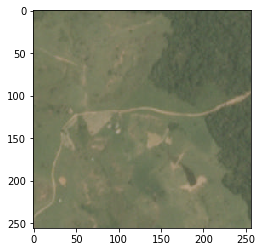

In [6]:
# show a sample image
plt.imshow(plt.imread(train_jpg.ls()[0]))

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [7]:
# filenames and their labels
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [8]:
# find the tags for train_23452
df.loc[df['image_name'] == 'train_23452']

,image_name,tags
23452,train_23452,agriculture clear cultivation habitation prima...


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we need to use `ImageItemList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

Data block API general guide

1. Where are the inputs and how to create them?
1. How to split the data into a training and validation sets?
1. How to label the inputs?
1. What transforms to apply?
1. How to add a test set? (optional; .`add_test_folder()`)
1. How to wrap in dataloaders and create the DataBunch?

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add `\`.

In [9]:
# 1. Where are the inputs
# 2. How to split the data
# 3. How to label

src = (ImageItemList.from_csv(path, csv_name='train_v2.csv', folder='train-jpg', suffix='.jpg') # 1. Where are the inputs
       .random_split_by_pct(0.2) # 2. How to split the data
       .label_from_df(label_delim=' ')) # 3. How to label (the 'tags' are separated by space)

In [10]:
# 4. What transforms to apply: flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.
# 5. Create the DataBunch: bs=32 (avoid cuda out of memory)
# normalize

tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = (src.transform(tfms, size=128) # 4. What transforms to apply?
        .databunch(bs=32).normalize(imagenet_stats)) # 6. Create the DataBunch

`show_batch` still works, and show us the different labels separated by `;`.

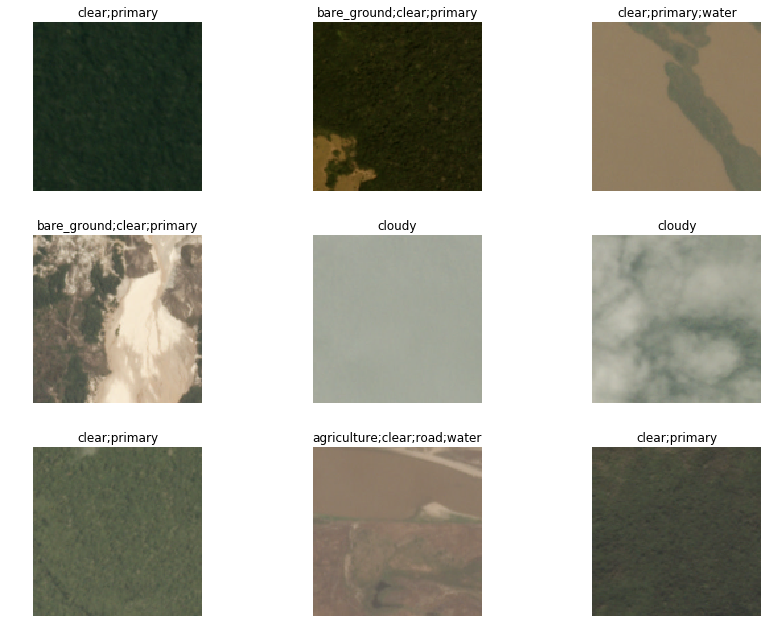

In [24]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [11]:
# define model architecture
arch = models.resnet50

In [12]:
# define accuracy and fscore functions
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
# create learner object (convert to fp16)
learn = create_cnn(data, arch, metrics=[acc_02, f_score]).fp16()

We use the LR Finder to pick a good learning rate.

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


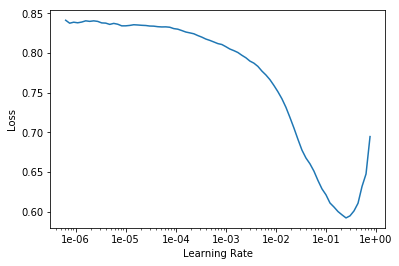

In [28]:
learn.recorder.plot()

Then we can fit the head of our network.

In [13]:
lr = 0.01

In [30]:
# train for 5 cycles
# warning: this will take 8 minutes to train (fp32); 4 mintues (fp16)
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.125141,0.108369,0.944432,0.904499
2,0.111180,0.095939,0.952418,0.916977
3,0.099952,0.091986,0.954068,0.921580
4,0.096421,0.088107,0.955957,0.922459
5,0.091612,0.086853,0.956087,0.923668


In [31]:
# save this stage
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [32]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


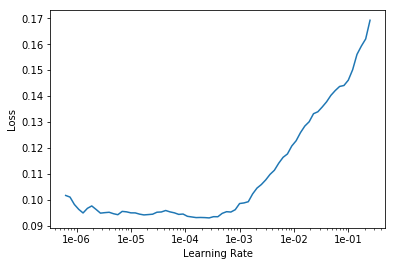

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
# finetune: train 5 more cycles
# time to train: 7 minutes (fp16)
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.098960,0.093779,0.954511,0.918868
2,0.097852,0.091353,0.951415,0.922165
3,0.091413,0.086118,0.959430,0.925812
4,0.086990,0.083196,0.957628,0.928175
5,0.078332,0.083106,0.958653,0.928411


In [35]:
# save this stage
learn.save('stage-2-rn50')

In [14]:
learn.load('stage-2-rn50')

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (32384 items)
[MultiCategory haze;primary, MultiCategory clear;primary, MultiCategory clear;primary, MultiCategory haze;primary;water, MultiCategory agriculture;clear;cultivation;primary;water]...
Path: /home/paperspace/.fastai/data/planet
x: ImageItemList (32384 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/paperspace/.fastai/data/planet;

Valid: LabelList
y: MultiCategoryList (8095 items)
[MultiCategory clear;primary;road, MultiCategory clear;primary;water, MultiCategory clear;conventional_mine;habitation;primary;road;water, MultiCategory cloudy, MultiCategory agriculture;clear;cultivation;cultivation;habitation;primary;road;water]...
Path: /home/paperspace/.fastai/data/planet
x: ImageItemList (8095 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/paperspace/

In [15]:
# create a new dataset
# use a larger size: 256. Dont forget to create a databunch & normalize
# use batch size 32 to avoid running out of cuda memory
data = (src.transform(tfms, size=256)
        .databunch(bs=32).normalize(imagenet_stats))

# replace the dataset
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [16]:
# freeze the model
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


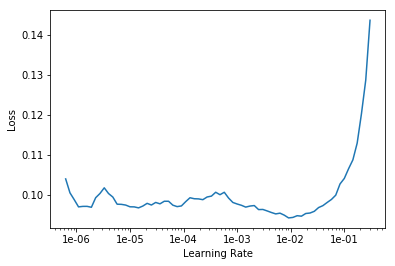

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
lr=1e-2/2

In [19]:
# train the model (this time with larger image res)
# warning: this will take 28 minutes to train (fp32); 13 minutes (fp16)
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.087196,0.084408,0.955899,0.926504
2,0.088506,0.083392,0.956611,0.927630
3,0.084169,0.082816,0.960026,0.929378
4,0.082285,0.081712,0.958755,0.928898
5,0.079557,0.081176,0.958726,0.930297


In [20]:
# save
learn.save('stage-1-256-rn50')

In [21]:
# unfreeze
learn.unfreeze()

In [22]:
# finetune
# warning: this will take 35 minutes to train (fp32)
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.084021,0.083807,0.956451,0.927824
2,0.083260,0.087381,0.958260,0.921903
3,0.084659,0.082745,0.957148,0.926965
4,0.080167,0.081235,0.959612,0.930742
5,0.074849,0.080842,0.959089,0.931498


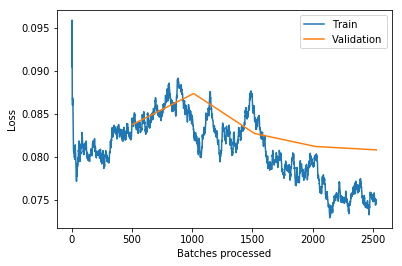

In [23]:
learn.recorder.plot_losses()

In [24]:
# save
learn.save('stage-2-256-rn50')